In [1]:
import cv2
from cv2 import aruco
import numpy as np
import msgpack as mp
import msgpack_numpy as mpn
import os
import matplotlib.pyplot as plt

In [2]:
_pth = os.path.dirname(os.getcwd())
_parent_folder = "data"
_calib_folder_name = "calib_hres_af"

_webcam_calib_folder = os.path.join(
    _pth, _parent_folder, "calibration", _calib_folder_name
)
_webcam_calib_video = os.path.join(_webcam_calib_folder, "webcam_color.msgpack")
_webcam_calib_folder = os.path.join(_webcam_calib_folder)
_webcam_calib_pth = os.path.join(_webcam_calib_folder, "webcam_calibration.msgpack")

In [3]:
ARUCO_PARAMETERS = aruco.DetectorParameters()
ARUCO_DICT = aruco.getPredefinedDictionary(aruco.DICT_ARUCO_ORIGINAL)
detector = aruco.ArucoDetector(ARUCO_DICT, ARUCO_PARAMETERS)
markerLength = 0.05
markerSeperation = 0.01

board = aruco.GridBoard(
    size=[1, 1],
    markerLength=markerLength,
    markerSeparation=markerSeperation,
    dictionary=ARUCO_DICT,
)
_video_pth = _webcam_calib_video
_video_file = open(_video_pth, "rb")
_video_data = mp.Unpacker(_video_file, object_hook=mpn.decode)
_video_length = 0

for _frame in _video_data:
    _video_length += 1

_video_file.close()

In [4]:
_video_pth = _webcam_calib_video
_video_file = open(_video_pth, "rb")
_video_data = mp.Unpacker(_video_file, object_hook=mpn.decode)

marker_corners = []
marker_ids = []
counter = 0
rnd = np.random.choice(_video_length, 150, replace=False)
for idx, _frame in enumerate(_video_data):
    if idx in rnd:
        corners, ids, rejected_image_points = detector.detectMarkers(_frame)

        corners, ids, _, _ = detector.refineDetectedMarkers(
            _frame, board, corners, ids, rejected_image_points
        )

        if ids is not None:
            marker_corners.append(corners)
            marker_ids.append(ids)
            counter += 1

_video_file.close()

In [5]:
processed_image_points = []
processed_object_points = []
for _f in range(len(marker_corners)):
    current_object_points, current_image_points = board.matchImagePoints(
        marker_corners[_f], marker_ids[_f]
    )
    try:
        if current_object_points.any() and current_image_points.any():
            processed_image_points.append(current_image_points)
            processed_object_points.append(current_object_points)
    except:
        pass

In [20]:
calibration_flags = cv2.CALIB_USE_QR
term_criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-6)

In [7]:
calibration_flags

4

In [8]:
mtx2 = np.eye(3)
dist2 = np.zeros((1, 8))

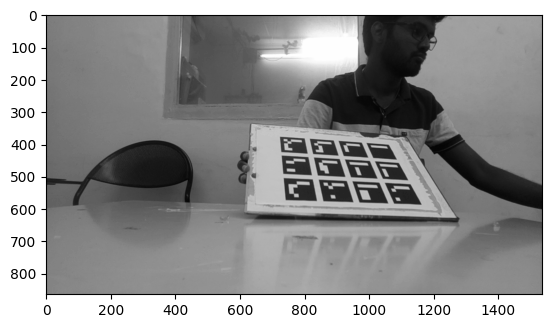

In [9]:
plt.imshow(_frame, cmap="gray")

In [21]:
_, mtx1, dist1, _, _ = cv2.calibrateCamera(
    processed_object_points,
    processed_image_points,
    _frame.shape[:2],
    mtx2,
    dist2,
    flags=calibration_flags,
    criteria=term_criteria,
)
# _, mtx1, dist1, _, _=cv2.calibrateCamera(processed_object_points, processed_image_points, _frame.shape[:2], mtx2, dist2)

In [16]:
mtx1

array([[1.90490449e+03, 0.00000000e+00, 4.31500000e+02],
       [0.00000000e+00, 1.47374811e+03, 7.67500000e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [17]:
dist1

array([[-0.01427831,  0.48084569,  0.03338995, -0.0274992 , -0.61919339]])

In [22]:
import toml

data = toml.load("/home/sujith/Documents/programs/settings.toml")
data["calibration"]["camera_matrix"] = mtx1.tolist()
data["calibration"]["dist_coeffs"] = dist1.tolist()
data["camera"]["resolution"] = _frame.shape[:2]
with open("/home/sujith/Documents/programs/calib_testing.toml", "w") as f:
    toml.dump(data, f)

In [19]:
_frame.shape

(864, 1536)